<a href="https://colab.research.google.com/github/pharringtonp19/mecon/blob/main/notebooks/problem_sets/solutions/Problem_Set_Four_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
#@title Imports { display-mode: "form" }
%%capture 
!pip install jaxopt
import jax 
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp 
import jaxopt
from functools import partial 
import matplotlib.pyplot as plt 
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams
from mpl_toolkits import mplot3d
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
#@title Inverse { display-mode: "form" }
def inverse(f):

  def inverse_fn(q):
    
    def closure(p, q):
      return (f(p)-q)**2

    solver = jaxopt.GradientDescent(fun=closure, maxiter=2000)
    res = solver.run(jnp.ones(shape=()), q)
    return res.params

  return inverse_fn

### **Technical Material**

This problem set is more technical than the previous problem set. We will make sure to review the important concepts in class. From a practical standpoint, the problem sets asks you to define three related functions of interest. 

## **Introduction/Summary/High Level Understanding**

In this problem set, we work through the basic components that give rise to the existence of insurance markets. In part 1, we consider whether a risk averse individual is willing to take a certain gamble/lottery. We show that while the expected change in wealth is zero, the individual would prefer to not take the lottery. In part 2, we then consider whether an individual would be willing to  purchase a "collection of lotteries". We show that their willingness to pay for this collection of lotteries declines as the size of the collection increases. In part 3, we realize though that if one individual (aka an insurer) was properly compensated for this collection of lotteries then they would be willing to accept them. In part 4, by playing around with our model, we explore what aspects characteristics of the insurer influences its willingness to accept this collection of lotteries. 

### **Part 1**

Let's consider the following lottery where with probability $p=0.1$ you will $\$18$ and with probability $1-p$, you lose $\$2$. With a utility function defined as $u(x) = \sqrt{x}$, and an initial wealth of $\$30$, would you take the lottery?

In [3]:
initial_wealth = 30 

def v1(p, xs, u):
  return p*u(initial_wealth + xs[0]) + (1-p)*u(initial_wealth + xs[1])

print(f"Value of Lottery: {(v1(0.1, [18, -2], lambda x: jnp.sqrt(x)))**2}")
print(f"Value of Initial Wealth: {(v1(0.1, [0, 0], lambda x: jnp.sqrt(x)))**2}")
print(f"Expected Value of Lottery: {v1(0.1, [18, -2], lambda x: x)}")

Value of Lottery: 29.758909000736416
Value of Initial Wealth: 30.0
Expected Value of Lottery: 30.0


### **Part 2 (<font size="4" color="blue">Individuals</font>)**
Show how the **expected net value** and **willingness to pay** change as we increase the number of lotteries

In [4]:
def v2(p, xs, initial_wealth, u, n):
  outcomes = jax.random.choice(jax.random.PRNGKey(0), jnp.array(xs), shape=(50000,n), p=jnp.array([p, 1-p]))
  total_outcomes = jnp.sum(outcomes, axis=1) + initial_wealth
  values = jax.vmap(u)(total_outcomes)
  return jnp.mean(total_outcomes)-initial_wealth, (jnp.mean(values))**2-initial_wealth

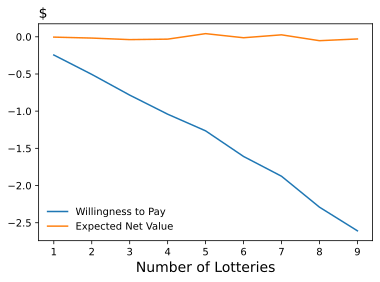

In [5]:
#@title Graph { display-mode: "form" }
p = 0.1 
xs = [18, -2]

v_fn = partial(v2, p, xs, initial_wealth, lambda x: jnp.sqrt(x))

expected_value_results = []
wtp_results = []
for i in range(1, 10):
  ans = v_fn(i)
  expected_value_results.append(ans[0])
  wtp_results.append(ans[1])

plt.plot(range(1, 10), wtp_results, label='Willingness to Pay')
plt.plot(range(1, 10), expected_value_results, label='Expected Net Value')
plt.title('$', loc='left', size=14)
plt.xlabel('Number of Lotteries', size=14)
plt.legend(frameon=False)
plt.show()

### **Part 3  (<font size="4" color="blue">Insurance Market</font>)**

Conisder the role of an insurer in this market. As highlighted in the graph above, consumers are willing to pay to avoid a lottery. Let's assume that they pay an insurance company to take the lottery. Show how the **expected net value** and **willingness to pay** changes as we increase the number of lotteries.

In [6]:
def v3(p, xs, initial_wealth_consumer, u_consumer, inital_wealth_insurer, u_insurer, n):
  expected_utils = p*u_consumer(xs[0]+initial_wealth_consumer) + (1-p)*u_consumer(xs[1]+initial_wealth_consumer)
  wtp = inverse(u_consumer)(expected_utils)
  payout = (initial_wealth_consumer - wtp)*n 
  outcomes = jax.random.choice(jax.random.PRNGKey(0), jnp.array(xs), shape=(50000,n), p=jnp.array([p, 1-p]))
  total_outcomes = jnp.sum(outcomes, axis=1) + inital_wealth_insurer + payout
  values = jax.vmap(u_insurer)(total_outcomes)
  return payout, jnp.mean(total_outcomes)-inital_wealth_insurer, inverse(u_insurer)(jnp.mean(values))-inital_wealth_insurer

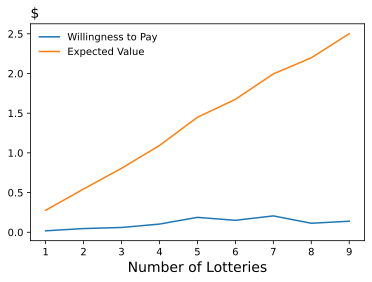

In [9]:
#@title Graph { display-mode: "form" }
v3_partial = partial(v3, p, xs, initial_wealth, lambda x: jnp.sqrt(x), initial_wealth, lambda x: jnp.sqrt(x))

expected_value_results = []
wtp_results = []
compensation = []
for i in range(1, 10):
  ans = v3_partial(i)
  compensation.append(ans[0])
  expected_value_results.append(ans[1])
  wtp_results.append(ans[2])

plt.plot(range(1, 10), wtp_results, label='Willingness to Pay')
plt.plot(range(1, 10), expected_value_results, label='Expected Value')
plt.title('$', loc='left', size=14)
plt.xlabel('Number of Lotteries', size=14)
plt.legend(frameon=False)
#plt.ylim(25, 35)
plt.show()

### **Part 4**
Play around the parameters that define the insurance company (initial wealth/ utility function). Do you see any changes to the graph? How would you explain these changes?

### **Bonus**
How does the above graph change if the lotteries are dependent?  